SuperFOV (Super Field-Of-View) Parallel Imaging + Banding Artifact Removal Reconstruction example

In [1]:
import sys
sys.path.append('..')

import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import normalized_root_mse
from skimage.restoration import unwrap_phase
from time import perf_counter
from skimage import io, transform

from michaelmendoza_ssfp import generate_ssfp_dataset
from michaelmendoza_ssfp.recons import gs_recon

In [2]:
def plot_dataset(data, slice = None, cmap='gray'):
    ''' Plots a slice of dataset of form: [Slice, Height, Width, Channel] '''

    slice = 0 if slice is None else slice
    npcs = data.shape[3]
    nx, ny = 2, int(npcs / 2)
    plt.figure()
    if(cmap):
        plt.set_cmap(cmap)
    for ii in range(nx*ny):
        _data = np.abs(data[slice, :, :, ii])
        plt.subplot(nx, ny, ii+1)
        plt.imshow(_data)
        plt.title('%d deg PC' % (ii*(360/npcs)))
        plt.xticks([])
        plt.yticks([])
    plt.show()

Generating 3d phantom:(1, 434, 362)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 71.67it/s]


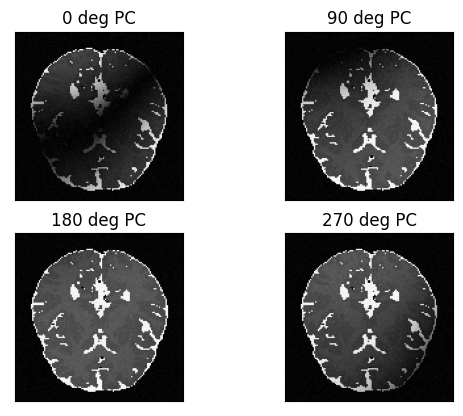

In [3]:
data = generate_ssfp_dataset(N=128, npcs=4, f=100, alpha=np.deg2rad(60), sigma=0.005, data_indices=[1, 150], rotate=True, deform=True)['M']
plot_dataset(data, slice=0)

In [4]:
print(data.shape)

(1, 128, 128, 4)


In [5]:
def fft2d(data, doInverse = False, axis = (1,2)):
    ''' Calculates 2D FFT for numpy data. Set doInverse = True to do ifft.  '''
    x, y = (axis)

    if (doInverse):
        fft = np.fft.ifft
        shift = np.fft.ifftshift
        unshift = np.fft.fftshift
        A = 1 * np.sqrt(data.shape[x]* data.shape[y]) 
    else:
        fft = np.fft.fft
        shift = np.fft.fftshift
        unshift = np.fft.ifftshift
        A = 1 / np.sqrt(data.shape[x]* data.shape[y]) 

    result = shift(shift(data, axes=(x,)), axes=(y,))
    result = fft(fft(result, axis = x), axis = y)
    result = unshift(unshift(result, axes=(x,)), axes=(y,))
    return A * result 

def ifft2d(data, axis=(1,2)):
    ''' Calculates 2D iFFT for numpy data. '''
    return fft2d(data, True, axis)

In [6]:
def acs(kspace, shape):
    ''' Samples the center lines of k-space for auto-calibrating singal (ACS) region. '''
    ny, nx = kspace.shape[1:3]
    [cny, cnx] = shape
    idxx = int(np.floor((nx - cnx) / 2))
    idxy = int(np.floor((ny - cny) / 2))
    result = kspace[:, idxy:idxy+cny, idxx:idxx+cnx, ...]
    return result

def undersample(data, type = 'SENSE', undersampling_ratio = 2, doFFT = True):
    ''' Undersampled data. Can only undersampled by integer values. '''
    if doFFT:
        data = fft2d(data)

    if type == "SENSE":
        ref = acs(data, (32,32))
        undersampling_ratio = int(undersampling_ratio)    
        mask = np.zeros(data.shape)
        mask[:, ::undersampling_ratio, ...] = 1
    
    data = data * mask
    return [data, ref]

In [7]:
def rsos(input):
    ''' Computes root sum of squares '''
    return np.sqrt(np.sum(np.square(np.abs(input)), axis = 3))

def sensitivity_map(data, axis = 3):
    ''' Generates a sensitivity map. Expects 4-d data (slice, height, width, channel) '''
    results = np.zeros(data.shape, dtype= complex)
    image = rsos(data)
    for i in range(data.shape[axis]):
        results[:,:,:,i] = data[:,:,:,i] / image
    return results

In [8]:
def SENSE(data, sensitivity_map, R):
    ''' SENSE Reconstruction for Parallel Imaging '''
    [height, width, coil] = sensitivity_map.shape
    results = np.zeros([height, width], dtype= complex)
    
    for y in range(int(height / R)):
        index = np.arange(y, height, int(height / R))
        for x in range(width):
            s = np.transpose(sensitivity_map[index, x, :].reshape(R, -1))
            M = np.matmul(np.linalg.pinv(s), data[y, x, :].reshape(-1, 1))    
            results[index, x] = M[:,0]
    return results

In [9]:
_ = undersample(data)
udata = _[0]
ref = _[1]

(1, 128, 128, 4)


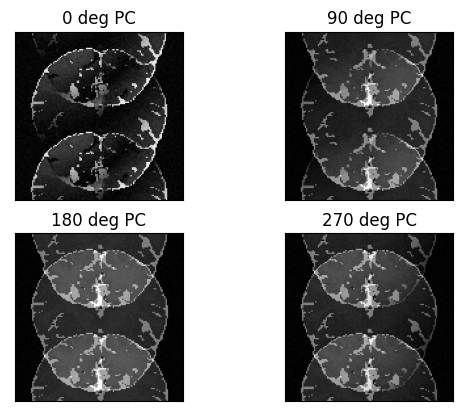

In [10]:
udata = ifft2d(udata)
print(udata.shape)
plot_dataset(udata)

(1, 32, 32, 4)


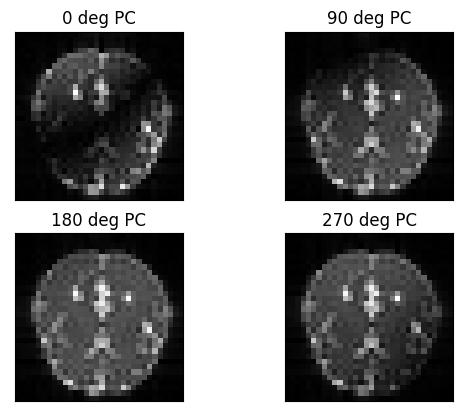

In [11]:
ref = ifft2d(ref)
print(ref.shape)
plot_dataset(ref)

(1, 32, 32, 4)


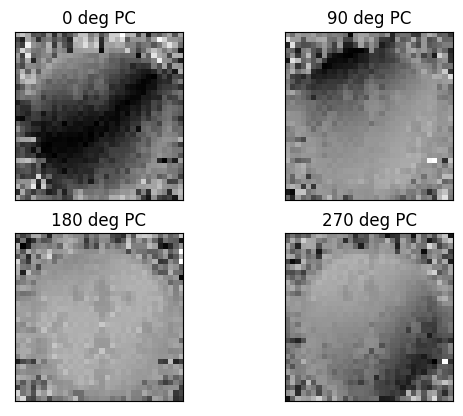

In [12]:
smap = sensitivity_map(ref)
print(smap.shape)
plot_dataset(smap)

In [13]:
def resize_complex(data, size):
    ''' Resize complex image to match a certain size '''
    data_real = transform.resize(np.real(data), size, mode='constant')
    data_img = transform.resize(np.imag(data), size, mode='constant')
    return data_real + 1j*data_img

# Resize smap to be size of undersampled data 
smap_ = resize_complex(smap, udata.shape)

(128, 128)


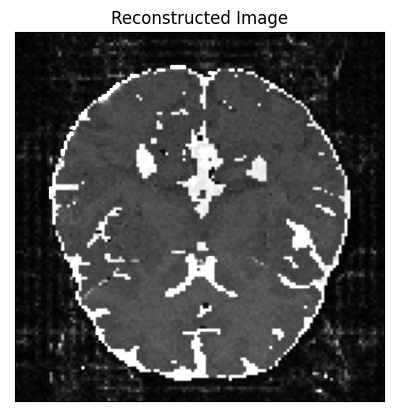

In [14]:
# Run SENSE reconstruction
recon = SENSE(udata[0], smap_[0], 2)
print(recon.shape)

plt.figure()
plt.imshow(np.abs(recon), vmax=0.3)
plt.title('Reconstructed Image')
plt.xticks([])
plt.yticks([])
plt.show()

In [15]:
max = np.max(np.abs(recon))
print(max)

1.5700724126900039


In [16]:
data = data.reshape((128,128,4))
print(data.shape)

(128, 128, 4)


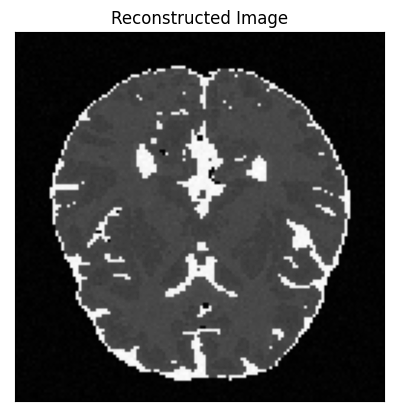

In [17]:
recon = gs_recon(data, pc_axis=2)
plt.figure()
plt.imshow(np.abs(recon))
plt.title('Reconstructed Image')
plt.xticks([])
plt.yticks([])
plt.show()